In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
from scipy.ndimage import gaussian_filter

import helpers

import pandas as pd
# import numpy as np
from PIL import Image
import PIL
import matplotlib as mpl

from skimage import exposure
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks
from scipy.signal import argrelextrema


In [2]:
def label_pipeline(img):
    """
    Applies functions for labeling image
    """
    # fix brightness and shadowing issues
    # https://stackoverflow.com/questions/44047819/increase-image-brightness-without-overflow/44054699#44054699

    norm_img = helpers.fix_brightness(img)
    
    # apply histogram equalization for vesicle picking
    # https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html#sphx-glr-auto-examples-color-exposure-plot-equalize-py
    imarr_hist = exposure.equalize_hist(norm_img)
    
    # remove data from outside of core

    # imarr_maskradius = helpers.remove_data_based_on_radius(imarr, mask_value=np.nan)
    imarr_hist = helpers.remove_data_based_on_radius(imarr_hist, mask_value=np.nan)

    sigma = 1
    blurs = gaussian_filter(imarr_hist, sigma=sigma)

    # calculate peaks
    peaks_etc = helpers.get_peaks_means_stds(blurs, height=1e3, width=4)

    # label peaks
    peak_labled = helpers.label_by_peaks(blurs, peaks_etc)

    
    # TODO : function this out
    # find local minima in histogram to separate vesicles from noise
    z = np.copy(peak_labled)
    z[z == 1] = 0
    # z[z == 2] = 3
    # z[z == 3] = 0

    z = gaussian_filter(z, sigma=4)

    h, e = np.histogram(z.flatten(), bins=np.linspace(0, 2, 201))
    try:
        splitter = e[argrelextrema(h, np.less, order=10)][0]
    except:
        splitter = e[argrelextrema(h, np.greater, order=10)[0]]
        
    z[z >= splitter] = 2
    z[z < splitter] = 0

    # calculate global mean and rescale values

    zim = helpers.zscore(helpers.remove_data_based_on_radius(img, np.nan))

    # filter out all data that is not fracture

    zim_remove = zim.copy()
    zim_remove[zim_remove > -1.75] = 0
    # zim_remove[zim_remove > -4] = 0

    x1, y1 = zim_remove.nonzero()

    zeros = np.zeros_like(zim_remove)

    zeros[x1, y1] = 1

    # replace all data as either 1 or 0 for fracture identification

    # footprint condition says value should be greater
    # in all directions
    footprint1 = np.array(
        [[1, 1, 1]
        ,[1, 0, 1]
        ,[1, 1, 1]]
    )

    footprint2 = np.array(
        [[1, 1, 1, 1, 1]
        ,[1, 1, 1, 1, 1]
        ,[1, 1, 0, 1, 1]
        ,[1, 1, 1, 1, 1]
        ,[1, 1, 1, 1, 1]]
    )

    # creates a window based on the given footprint
    # to compare neighbors and replace values on 
    # nearest maximum value
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.maximum_filter.html
    newim = ndimage.median_filter(zeros, footprint=footprint1, mode='constant')
#     newim = ndimage.median_filter(zeros, footprint=footprint2, mode='constant')
    newim = ndimage.maximum_filter(newim, footprint=footprint2, mode='constant')

    imlabeled = helpers.remove_data_based_on_radius(newim, mask_value=np.nan)

    # create new labeled image
    zeros = np.zeros_like(imlabeled)

    ves_x, ves_y = z.nonzero()
    zeros[ves_x, ves_y] = 1

    frac_x, frac_y = imlabeled.nonzero()
    zeros[frac_x, frac_y] = 2

    zeros = helpers.remove_data_based_on_radius(zeros, np.nan)
    
    return zeros

In [ ]:
filenames = !ls benoitdata/F20_10_b/

for file in filenames:
#     file = 'benoitdata/F20_10_b/'+file
    print(file)
#     file = 'benoitdata/F20_10_b/6um_jamtveit_att_pag-1.99_3.12_00030.tif'

    img = cv2.imread('benoitdata/F20_10_b/'+file,0)
    i = label_pipeline(img)
    np.savetxt(X=i, fname='labeled/'+file+'_labeled.dat', delimiter=',')
#     np.savetxt(X=i, fname='labeled/6um_jamtveit_att_pag-1.99_3.12_00030.tif_labeled.dat', delimiter=',')
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    ax[0].imshow(exposure.equalize_hist(img), cmap='plasma')
    ax[1].imshow(i, cmap='plasma')
    fig.tight_layout()
    fig.savefig('labeled/'+file+'_labeled.png', dpi=300, bbox_inches='tight')
#     fig.savefig('labeled/6um_jamtveit_att_pag-1.99_3.12_00030.tif_labeled.png', dpi=300, bbox_inches='tight')
#     break

6um_jamtveit_att_pag-1.99_3.12_00000.tif
6um_jamtveit_att_pag-1.99_3.12_00001.tif
6um_jamtveit_att_pag-1.99_3.12_00002.tif
6um_jamtveit_att_pag-1.99_3.12_00003.tif
6um_jamtveit_att_pag-1.99_3.12_00004.tif


In [ ]:
# TODO:
# 1. multiprocess this
# 2. figure out splitter function
# 3. print out more figures to not make it so black box
# 4. go through all the figures created to see how good its doing

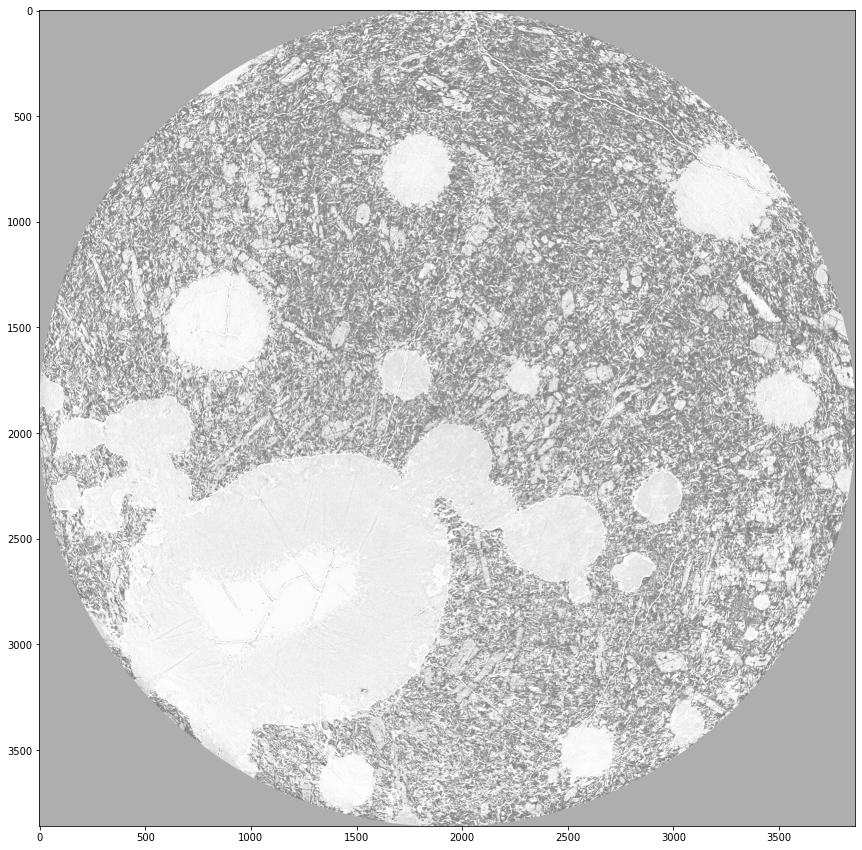

In [7]:
fig, ax = plt.subplots(figsize=(15, 15))

ax.imshow(exposure.equalize_hist(img), cmap='Greys', alpha=0.5)
# ax.imshow(i, alpha=0.5, cmap='plasma')

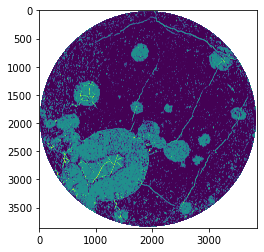

In [8]:
plt.imshow(i)

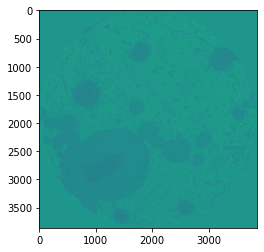

In [22]:
plt.imshow(img)

In [11]:
# filename = 'benoitdata/F20_10_b/6um_jamtveit_att_pag-1.99_3.12_00030.tif'
filename = 'benoitdata/F20_10_b/6um_jamtveit_att_pag-1.99_3.12_00005.tif'

img = cv2.imread(filename,0)
# img = cv2.imread(file,0)


In [12]:
img

In [ ]:
# fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# ax[0].imshow(exposure.equalize_hist(img), cmap='plasma')
# ax[1].imshow(zeros, cmap='plasma')
# fig.tight_layout()

In [ ]:
# zeros = label_pipeline(img)

In [ ]:
# fig, ax = plt.subplots(figsize=(20, 20))

# ax.imshow(zeros, cmap='inferno')